# 프로젝트: ControlNet으로 조건을 준 이미지 생성하기
## 개요
지금까지는 Stable Diffusion 모델만을 이용하여 이미지를 생성하거나 이미지의 스타일을 바꾸는 실습을 해보았습니다.   
이번에는 여기서 조금 더 나아가서 ControlNet을 사용하여 이미지에 조건을 주어 이미지를 다양하게 변형해보려고 합니다.  

## 목차
1. ControlNet 소개
2. 윤곽선 검출 : Canny 알고리즘을 활용
3. 인체 자세 감지 : Openpose를 활용
4. 윤곽선 검출 + 인체 자세 감지

## 회고

## Reference

---

# 1. ControlNet 소개
Stable Diffusion은 텍스트 프롬프트 또는 입력 이미지를 통하여 이미지를 생성하지만 생성된 이미지를 원하는 대로 출력하기 어렵습니다.   
아무리 프롬프트를 자세하게 써도 생성되는 이미지가 내가 원하는 자세, 구도, 배경을 갖도록 하는 것은 거의 불가능하죠.   

## ControlNet은 
- Diffusion 모델에 추가 조건을 추가하여 출력되는 이미지를 쉽게 제어할 수 있습니다.
- 뿐만 아니라 ControlNet은 훈련 데이터가 작아도 학습이 잘 되고 빠르다는 장점이 있어 개인용 기기에서 사용할 수 있다는 장점이 있습니다.  
- ControlNet은 논문 'Adding Conditional Control to Text-to-Image Diffusion Models'에서 소개되었고, 외곽선 감지(Canny Edge detection), 인체 자세 감지(Human pose), 낙서 지도(Scribble map), 시맨틱 세그멘테이션(Semantic segmentation) 등 다양한 전처리기(Preprocessor)를 Stable Diffusion 모델에 도입할 수 있습니다. 그래서 원하는 자세, 구도 등으로 이미지를 생성할 수 있습니다.

![controlnet](https://d3s0tskafalll9.cloudfront.net/media/images/HwaMyeon_KaebCheo_2023-05-04_181336.max-800x600.png)  

ControlNet의 원리나 구조도 중요하지만 그건 추후에 개인적으로 공부하기로 하고, 여기서는 ControlNet을 사용하여 이미지를 어떻게 제어할 수 있는지를 프로젝트를 통해 알아보겠습니다. 😁

이번 프로젝트는 [허깅페이스에서 제공하는 실습 코드](https://huggingface.co/docs/diffusers/v0.17.1/en/api/pipelines/stable_diffusion/overview)를 수정 및 재구성하였습니다.  

먼저 필요한 라이브러리를 설치하겠습니다.  

In [1]:
# Stable Diffusion library 설치
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [2]:
# 이미지 생성 시 CUDA out of memery가 나온다면 --> 메모리 삭제
# torch.cuda.empty_cache()

# 2. 윤곽선 검출
윤곽선을 검출해 봅니다.  
ControlNet은 다양한 윤곽선 검출 알고리즘을 제공하지만 우리는 가장 유명하고 효과적인 윤곽선 검출 알고리즘인 Canny 알고리즘을 사용하겠습니다.  

먼저 이미지를 불러옵니다. 누구나 익히 아는 이미지를 사용하였습니다.

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

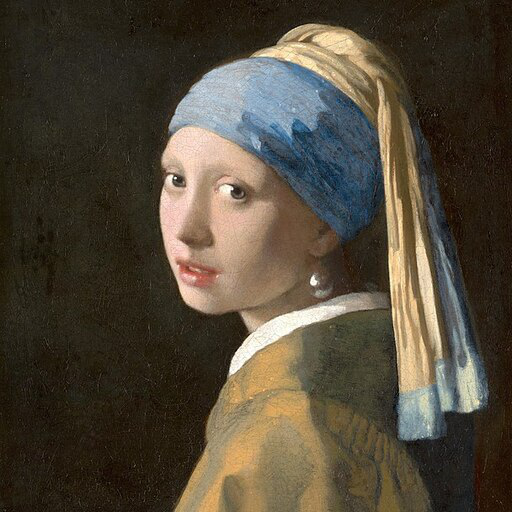

In [2]:
import torch
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image 

# 이미지 불러오기
image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)

image

# StableDiffusionControlNetPipeline 클래스 : Stable Diffusion을 제어하기 위한 파이프라인을 나타냅니다.

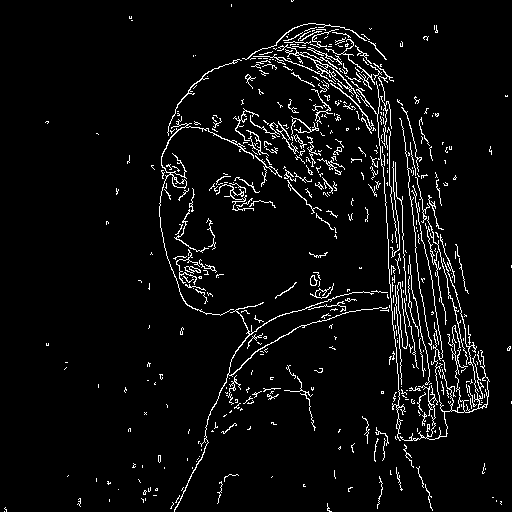

In [3]:
# OpenCV를 사용하여 이미지의 윤곽선을 검출

import cv2
from PIL import Image 
import numpy as np

# 이미지를 NumPy 배열로 변환합니다. 
image = np.array(image)

# threshold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 윤곽선을 검출합니다. 
image = cv2.Canny(image, low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)  # NumPy 배열을 PIL 이미지로 변환합니다. 

canny_image


# import cv2: 컴퓨터 비전 작업을 위해 OpenCV 라이브러리를 가져옵니다.
# from PIL import Image: Python 이미징 라이브러리에서 Image 클래스를 가져옵니다.
# import numpy as np: 수치 계산을 위해 NumPy 라이브러리를 가져옵니다.
# image = np.array(image): 입력 이미지(PIL 이미지로 가정)를 NumPy 배열로 변환합니다.
# low_threshold = 100 및 high_threshold = 200: Canny 가장자리 감지 알고리즘을 사용하여 가장자리 감지에 대한 낮은 임계값과 높은 임계값을 지정합니다.
# image = cv2.Canny(image, low_threshold, high_threshold): 지정된 임계값을 사용하여 Canny 가장자리 감지 알고리즘을 사용하여 입력 이미지에서 가장자리를 감지합니다.
# image = image[:, :, None]: 배열에 새로운 차원(None)을 추가합니다. [:, :, None]는 [행, 열, 새로운 축]으로 행과 열의 전체 요소를 선택하고 새 축을 추가합니다.
# image = np.concatenate([image, image, image], axis=2) : 
# [image, image, image]: 이 목록에는 image 배열의 복사본 3개가 포함되어 있습니다. 이는 본질적으로 각 배열이 원본 '이미지' 배열의 복사본인 배열 목록을 생성하는 것입니다.
# axis=2 : 이미지의 채널 축에 해당하는 세 번째 축(인덱스 2의 축)을 따라 연결이 수행됨을 의미
# 즉, image 배열의 세 복사본을 채널 축(축 2)을 따라 결합하여 효과적으로 새로운 3D 배열을 생성합니다.
# 여기서 원래 '이미지' 배열은 채널 축을 따라 세 번 반복됩니다. 
# 이 작업은 일반적으로 RGB 또는 회색조 이미지와 같은 다중 채널 이미지를 생성하기 위한 이미지 처리에 사용됩니다.

In [4]:
# 윤곽선 검출 전처리기를 사용한 모델 파이프라인을 불러오기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel

canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
canny_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=canny_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

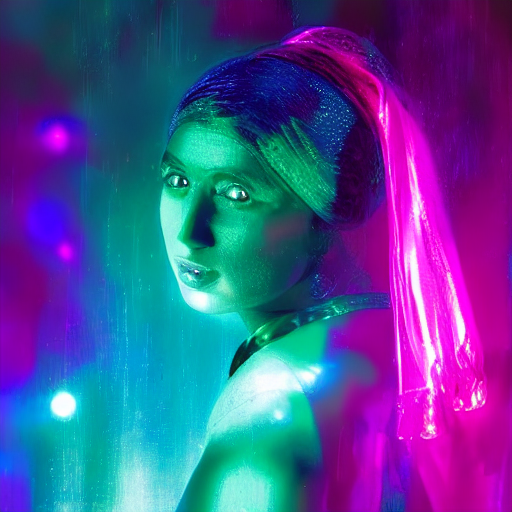

In [5]:
# 새로운 이미지를 생성하기 - 윤곽선을 추출한 이미지에 프롬프트를 적용하여 

from diffusers import UniPCMultistepScheduler
# 기존 스케줄러 구성에서 생성된 UniPCMultistepScheduler 인스턴스로 canny_pipe 인스턴스의 스케줄러를 업데이트합니다.
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# canny_pipe 인스턴스를 CUDA 장치로 이동
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

프롬프트 외에도 부정적인 프롬프트(negative_propmt)를 넣을 수도 있고, 하이퍼파라미터를 조절할 수도 있습니다.  

- negative_propmt: 원하지 않는 요소를 적을 수 있습니다.
- controlnet_conditioning_scale: ContorlNet으로 조건을 어느 정도 주느냐를 조절합니다. Default는 1이고, 실수값으로 설정할 수 있습니다.
- num_inference_steps: 추론 횟수로, 값이 커질수록 고해상도 이미지가 출력되지만 출력되는 시간이 오래 걸립니다. default 값은 50입니다.
- guidance_scale: 얼마나 주어진 프롬프트에 근접한 이미지를 생성할지를 설정하는 하이퍼파라미터로, 값이 커질수록 문자열에 근접한 이미지가 생성되지만 이미지 품질이 떨어질 수 있습니다. default는 7.5입니다.  

프롬프트와 부정적인 프롬프트는 ChatGPT를 이용하여 생성해 보세요. 직접 프롬프트를 작성하는 것보다 더 멋진 이미지를 생성할 수 있어요.

In [7]:
# Prompt: Subject: Disco dancer
# Setting: Colorful lights
# Action: Dancing
# Context: Disco club
# Environment: Vibrant and energetic
# Lighting: Flashing and dynamic
# Artist: Skilled dancer
# Style: Groovy and rhythmic
# Medium: Digital art
# Type: Illustration
# Color Scheme: Bright and neon
# Computer Graphics: High-quality rendering
# Quality: Detailed and expressive

# Positive Prompt:
# A skilled disco dancer is energetically dancing under vibrant and colorful lights in a disco club. The lighting is flashing and dynamic, creating a groovy and rhythmic atmosphere. The digital illustration showcases a bright and neon color scheme with high-quality rendering, resulting in a detailed and expressive artwork.

# Negative Prompt:
# Negative Prompts: dark, still, quiet, monochromatic, dull, low-quality, blurry

  0%|          | 0/20 [00:00<?, ?it/s]

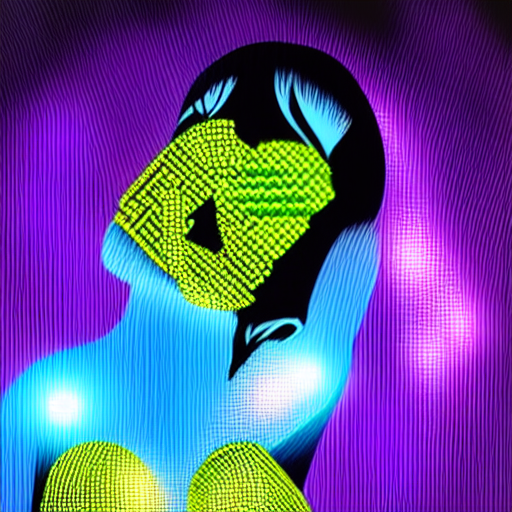

In [8]:
# 부정적인 프롬프트 추가해보기

from diffusers import UniPCMultistepScheduler
# 기존 스케줄러 구성에서 생성된 UniPCMultistepScheduler 인스턴스로 canny_pipe 인스턴스의 스케줄러를 업데이트합니다.
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# canny_pipe 인스턴스를 CUDA 장치로 이동
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    negative_prompt="dark, still, quiet, monochromatic, dull, low-quality, blurry",
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/20 [00:00<?, ?it/s]

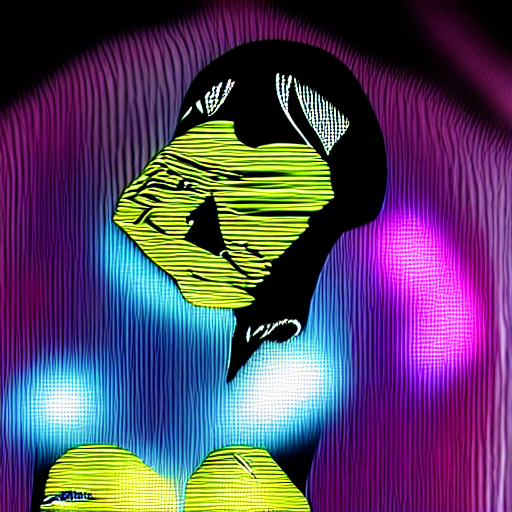

In [9]:
# 하이퍼파라미터 변경 - controlnet_conditioning_scale

from diffusers import UniPCMultistepScheduler
# 기존 스케줄러 구성에서 생성된 UniPCMultistepScheduler 인스턴스로 canny_pipe 인스턴스의 스케줄러를 업데이트합니다.
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# canny_pipe 인스턴스를 CUDA 장치로 이동
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    controlnet_conditioning_scale=1.5,
    num_inference_steps=20, 
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

  0%|          | 0/20 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


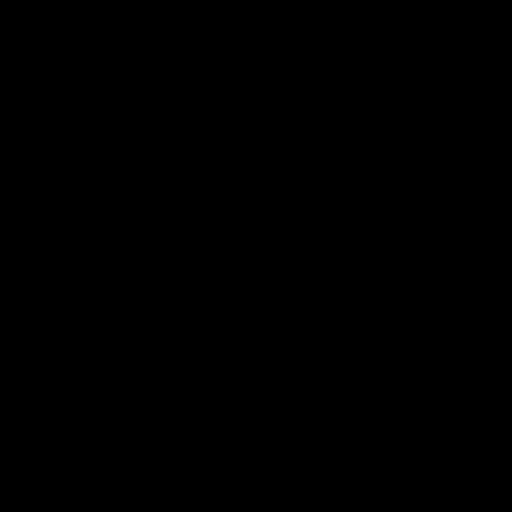

In [10]:
# 하이퍼파라미터 변경 - controlnet_conditioning_scale, guidance_scale

from diffusers import UniPCMultistepScheduler
# 기존 스케줄러 구성에서 생성된 UniPCMultistepScheduler 인스턴스로 canny_pipe 인스턴스의 스케줄러를 업데이트합니다.
canny_pipe.scheduler = UniPCMultistepScheduler.from_config(canny_pipe.scheduler.config)
# canny_pipe 인스턴스를 CUDA 장치로 이동
canny_pipe = canny_pipe.to("cuda")

# 동일한 이미지를 생성하기 위해 seed를 지정합니다. 
generator = torch.manual_seed(0)  

# 이미지를 생성합니다. 
canny_image = canny_pipe(
    prompt="disco dancer with colorful lights", 
    controlnet_conditioning_scale=1.5,
    num_inference_steps=20, 
    guidance_scale=8.0,
    generator=generator, 
    image=canny_image
).images[0]

# 생성된 이미지를 저장합니다. 
canny_image.save("/aiffel/aiffel/canny_image.png")  

# 생성된 이미지를 출력합니다. 
canny_image

출력 메세지의 의미 :  
생성된 이미지에 작업하기에 안전하지 않은 콘텐츠(NSFW)가 포함되어 있을 수 있음을 의미합니다.   
예방 조치로 생성된 이미지는 부적절할 수 있는 콘텐츠가 표시되는 것을 방지하기 위해 검은색 이미지로 대체됩니다. NSFW 콘텐츠 없이 이미지를 생성하려면 생성 프로세스에 대해 다른 프롬프트 및/또는 시드를 사용해야 할 수도 있습니다.

# 3. 인체 자세 감지
Openpose는 인체 자세 감지(Human pose)를 할 수 있는 전처리기입니다. 자세를 감지하여 새로운 이미지를 생성해 줍니다.  

먼저 사람의 전신이 담긴 이미지를 불러오겠습니다.

In [6]:
# controlnet-aux를 설치합니다. Human pose를 검출해주는 controlnet의 보조용 모델입니다.
!pip install controlnet-aux==0.0.1

     |████████████████████████████████| 44 kB 3.4 MB/s             


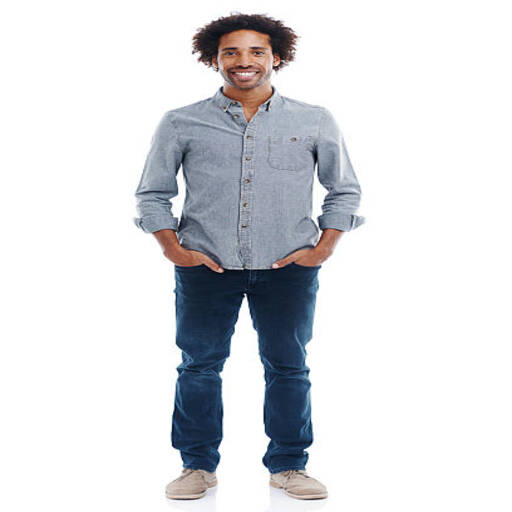

In [7]:
# 사람 전신 이미지 불러오기

from diffusers.utils import load_image

openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)
openpose_image

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

cuda


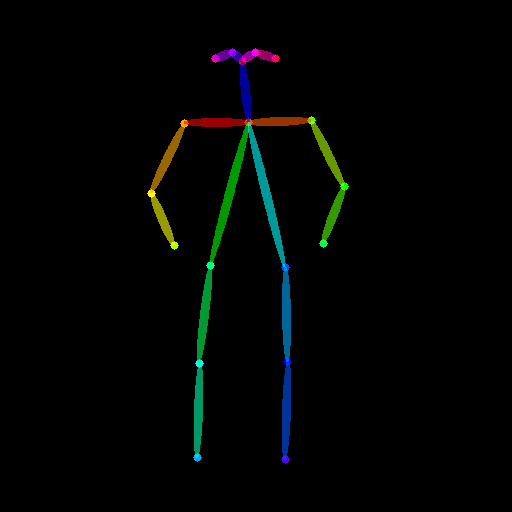

In [8]:
# Openpose 검출기를 사용하여 자세만 추출

from controlnet_aux import OpenposeDetector

# 인체의 자세를 검출하는 사전 학습된 ControlNet 불러오기
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")

# 이미지에서 자세 검출
openpose_image = openpose(openpose_image)
openpose_image

In [9]:
# Openpose 전처리기를 사용한 모델 파이프라인을 불러오기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel 

openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
openpose_pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=openpose_controlnet, torch_dtype=torch.float16
)

config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.45G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

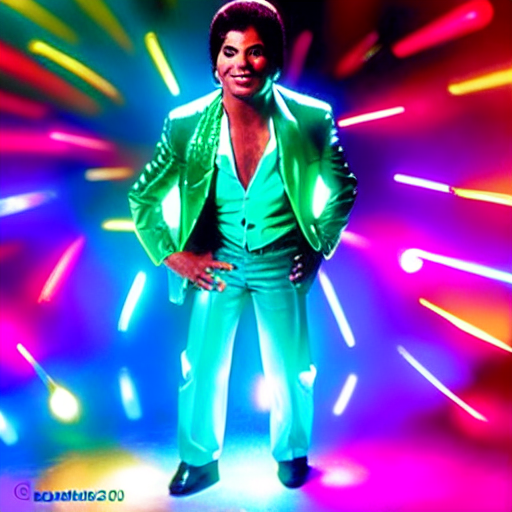

In [10]:
# 새로운 이미지 생성해보기

from diffusers import UniPCMultistepScheduler

openpose_pipe.scheduler = UniPCMultistepScheduler.from_config(openpose_pipe.scheduler.config)
openpose_pipe = openpose_pipe.to("cuda")

# Q. 코드를 작성해 보세요.
# 동일한 이미지를 생성하기 위해 seed를 넣어줍니다. 
generator = torch.manual_seed(0)

#프롬프트를 작성합니다. 
prompt = "disco dancer with colorful lights"
negative_prompt = "dark, still, quiet, monochromatic, dull, low-quality, blurry"

# 이미지를 생성합니다. 
openpose_image1 = openpose_pipe(
    prompt = "disco dancer with colorful lights", 
    negative_prompt = "dark, still, quiet, monochromatic, dull, low-quality, blurry", 
    num_inference_steps=20, 
    generator=generator, 
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image1

  0%|          | 0/30 [00:00<?, ?it/s]

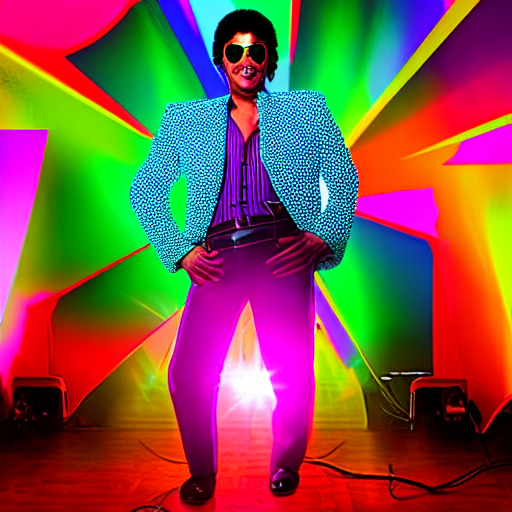

In [16]:
# 하이퍼파라미터 변경 - 새로운 이미지 생성 
openpose_image2 = openpose_pipe(
    prompt = "disco dancer with colorful lights", 
    negative_prompt = "dark, still, quiet, monochromatic, dull, low-quality, blurry", 
    num_inference_steps=30, 
    guidance_scale=8.0, 
    generator=generator, 
    image=openpose_image
).images[0]

# 생성된 이미지를 출력합니다. 
openpose_image2

# 4. 윤곽선 검출 + 인체 자세 감지
이번에는 위에서 실습한 2가지의 전처리기를 동시에 사용해 보겠습니다. 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달하면 됩니다.  

## Canny 알고리즘을 사용한 윤곽선 검출
먼저 Canny 알고리즘으로 윤곽선을 검출합니다.   
Canny 알고리즘으로 윤곽선을 검출한 이미지 위에 인체 자세 검출 전처리기를 올려줄 것이기 때문에 인체 자세를 넣어줄 부분을 이미지 내에서 지워주어야 한다는 점을 주의하세요.

In [16]:
from diffusers.utils import load_image 
from PIL import Image
import cv2
import numpy as np
from diffusers.utils import load_image

# Q. 코드를 작성해 보세요.
# 이미지를 불러오세요. 
canny_image = load_image(
    "https://hf.co/datasets/huggingface/documentation-images/resolve/main/diffusers/input_image_vermeer.png"
)
canny_image = canny_image.convert("L")  # Convert to grayscale.

#threshhold를 지정합니다. 
low_threshold = 100
high_threshold = 200

# 이미지를 NumPy 배열로 변환합니다. 
canny_image = np.array(canny_image)

# 인체 감지 포즈를 넣어줄 가운데 부분을 지워줍니다. 
zero_start = canny_image.shape[1] // 4
zero_end = zero_start + canny_image.shape[1] // 2
canny_image[:, zero_start:zero_end] = 0

# 윤곽선을 검출하고 NumPy 배열을 PIL 이미지로 변환합니다. 
canny_image = cv2.Canny(canny_image, low_threshold, high_threshold)
canny_image = Image.fromarray(canny_image)  
canny_image = canny_image.convert("RGB")  # Convert back to RGB.

### Openpose를 사용한 인체 자세 검출
인체 자세를 검출해 줍니다.

In [17]:
# Openpose를 사용한 인체 자세 검출

from controlnet_aux import OpenposeDetector
from diffusers.utils import load_image 

# Q. 아래의 코드를 작성해 주세요.
# 이미지를 불러옵니다. 
openpose_image = load_image(
    "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/person.png"
)

# OpenposeDetector를 사용하여 인체 자세를 검출합니다. 
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose_image = openpose(openpose_image)

cuda


Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만들어 파이프라인으로 전달합니다.

In [18]:
# controlnets 리스트 만들어 파이프라인으로 전달하기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [canny_controlnet, openpose_controlnet] 

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "disco dancer with colorful lights"
negative_prompt = "dark, still, quiet, monochromatic, dull, low-quality, blurry"

# seed를 지정합니다. 
generator = torch.manual_seed(0)  

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=20, generator=generator, image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: 'aiffel/aiffel/multi_controlnet_output.png'

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

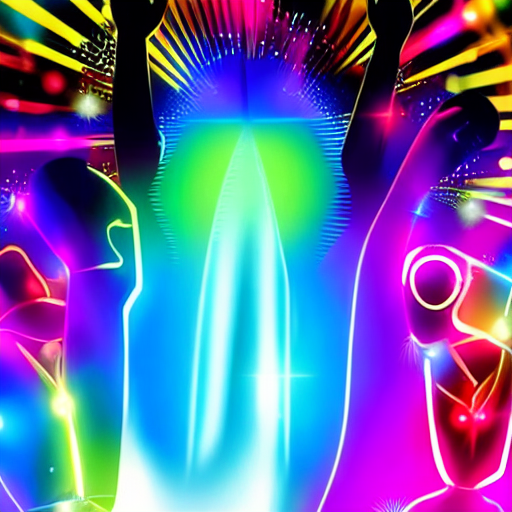

In [15]:
# controlnets 리스트 만들어 파이프라인으로 전달하기

from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler  

# Q. 코드를 작성해 보세요.
# Edge Detection과 Openpose, 2개의 전처리기를 controlnets라는 리스트로 만듭니다. 
canny_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
openpose_controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float16)
controlnets = [canny_controlnet, openpose_controlnet] 

# 리스트 controlnets를 파이프라인으로 전달합니다. 
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnets, torch_dtype=torch.float16
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

# 프롬프트를 작성합니다. 
prompt = "disco dancer with colorful lights"
negative_prompt = "dark, still, quiet, monochromatic, dull, low-quality, blurry"

# seed를 지정합니다. 
generator = torch.manual_seed(0)  

images = [openpose_image, canny_image]

# 이미지를 생성합니다. 
image = pipe(prompt=prompt, negative_prompt=negative_prompt, num_inference_steps=20, generator=generator, image=images).images[0]

# 생성된 이미지를 저장합니다.
image.save("/aiffel/aiffel/multi_controlnet_output.png")

# 생성된 이미지를 출력합니다.  
image

지금까지 ContolNet을 사용하여 이미지를 생성해 보았습니다. 

---
## 회고
### KEEP
파라미터를 다양하게 변경하며 실험해보았다.

### PROBLEM
오류를 해결하기 위해 코드를 재실행할 때마다 메모리 부족 오류가 뜨거나, 커널이 죽었다.

### TRY
Task를 수행하기 위한 최소한의 코드만 실행하고, 퍼실님이 말씀해주신 다른 테스트 방법들을 알아두어야겠다. [controlnet](https://stablediffusionweb.com/ControlNet#demo)

---

In [ ]:
# [참고]  
# CUDA메모리 오류 뜰 때, 코드에 이 부분 추가해서 진행해보기.
# 쿠다 사용 불가능할때 CPU로 대체하는 코드.  


# # 모델 설정 및 장치 선택
# model_id = "CompVis/stable-diffusion-v1-4"
# device = "cuda" if torch.cuda.is_available() else "cpu"

# # 모델 로드
# pipe = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# pipe = pipe.to(device)

# # 이미지 생성을 위한 설정
# num_images = 2
# prompts = ['A fantasy landscape, trending on artstation'] * num_images
# strength = 0.9
# guidance_scale = 13.5
# num_inference_steps = 50
# generator = torch.Generator(device=device).manual_seed(1024)

In [ ]:
# https://stablediffusionweb.com/ControlNet#demo
    
# 여기서 이미지 돌려보면서 테스트해보기